## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [20]:
#載入套件
from resnet_builder import resnet # 這是從 resnet_builder.py 中直接 import 撰寫好的 resnet 函數
from keras.datasets import cifar10
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
import os

In [21]:
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 75% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

In [22]:
#載入資料
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#查看資料大小
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
# y 值轉成 one-hot encoding，轉成10類
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test,10)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [23]:
# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [24]:
# 建立 ResNet 模型
model = resnet(input_shape=(32,32,3)) 
x = model.output
output_layer = Dense(10, activation='softmax', name='softmax')(x)

newModel = Model(inputs=model.input,outputs=output_layer)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, 32, 32, 16)   64          conv2d_125[0][0]                 
__________________________________________________________________________________________________
activation_113 (Activation)     (None, 32, 32, 16)   0           batch_normalization_113[0][0]    
____________________________________________________________________________________________

In [25]:
# 使用動態調整學習率
scheduler_lr = LearningRateScheduler(lr_schedule)

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
reduce_lr = ReduceLROnPlateau(factor=0.5, #學習速率被降低的因數。新的學習速率=學習速率*因數
                              min_lr=1e-12, #學習速率的下邊界。
                              monitor='val_loss', #被監測的數據
                              patience=5, #沒有進步的訓練輪數，在這之後訓練速率會被降低
                              verbose=1)  #日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄。

#加入 EarlyStop
earlystop = EarlyStopping(monitor="val_loss", #監控數據的接口
                          patience=7,         #能夠容忍多少個epoch內都沒有improvement
                          verbose=1  )        #日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄。
# 設定 callbacks
callbacks = [reduce_lr, scheduler_lr, earlystop]

In [26]:
#訓練用的超參數
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 30 # 訓練整個資料集共 30個循環

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

history = model.fit( x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,                    #訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期。
                    verbose=1,
                    validation_data=(x_test, y_test),   #驗證資料。
                    shuffle=True,
                    callbacks = callbacks
                   ) 

# 顯示損失函數、訓練成果(分數)
# verbose：日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄。
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Learning rate:  0.001
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
Learning rate:  0.001
50000/50000 [==============================] - 80s 2ms/step - loss: 1.7911 - accuracy: 0.5287 - val_loss: 1.6105 - val_accuracy: 0.5700
Epoch 2/30
Learning rate:  0.001
50000/50000 [==============================] - 72s 1ms/step - loss: 1.3107 - accuracy: 0.6677 - val_loss: 1.4275 - val_accuracy: 0.6226
Epoch 3/30
Learning rate:  0.001
50000/50000 [==============================] - 71s 1ms/step - loss: 1.1153 - accuracy: 0.7250 - val_loss: 1.1582 - val_accuracy: 0.6978
Epoch 4/30
Learning rate:  0.001
50000/50000 [==============================] - 71s 1ms/step - loss: 0.9854 - accuracy: 0.7643 - val_loss: 1.3479 - val_accuracy: 0.6359
Epoch 5/30
Learning rate:  0.001
50000/50000 [==============================] - 71s 1ms/step - loss: 0.8880 - accuracy: 0.7966 - val_loss: 1.2001 - val_accuracy: 0.7013
Epoch 6/30
Learning rate:  0.001
50

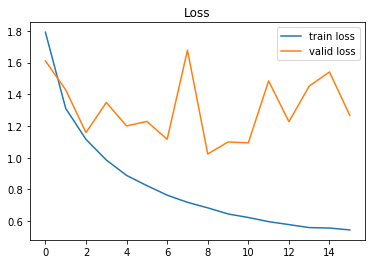

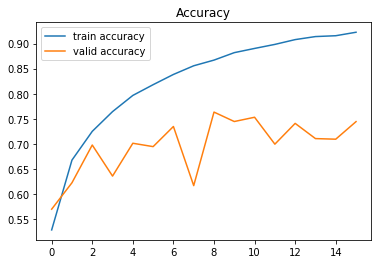

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()